<a href="https://colab.research.google.com/github/mldessu/projetsimu/blob/main/Chaleur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Équation considérée

Nous partons de l’équation de diffusion thermique :

$$
C_v\,\rho \,\frac{\partial T(x,t)}{\partial t}
\;=\;
k\,\frac{\partial^2 T(x,t)}{\partial x^2}
\;+\;
S(x),
$$

où :

- $T(x,t)$ est la température dans le mur,  
- $C_v$ est la capacité thermique massique,  
- $\rho$ la masse volumique,  
- $k$ la conductivité thermique,  
- $S(x)$ un terme source (ex. chauffage volumique interne).

---

## 2. Conditions aux limites en forme générale

### 2.1. Condition de Robin (convection) à \(x=0\)

La forme **générale** est :

$$
c_1\,\frac{\partial T}{\partial x}\Big|_{x=0}
\;+\;
c_2\,T(0,t)
\;+\;
c_3
\;=\;
0.
$$

Ici, nous avons :
$$
-\,k\,\frac{\partial T}{\partial x}(0,t)
\;=\;
h\,\bigl(T_a - T(0,t)\bigr)
$$
ce qui se réécrit :
$$
\underbrace{(-k)}_{c_1} \,\frac{\partial T}{\partial x}(0,t)
\;+\;
\underbrace{(h)}_{c_2}\,T(0,t)
\;+\;
\underbrace{(-h\,T_a)}_{c_3}
\;=\;
0.
$$

### 2.2. Condition de Dirichlet (température imposée) à \(x=L\)

Pour imposer \(T(L,t) = T_i\), la forme générale serait :

$$
d_1\,\frac{\partial T}{\partial x}\Big|_{x=L}
\;+\;
d_2\,T(L,t)
\;+\;
d_3
\;=\;
0,
$$


---

## 3. Grandes étapes du code

1. **Définir les paramètres** physiques (\(k, h, $C_v$, $\rho$)) et géométriques (L, N, etc.).  
2. **Mailler** l’espace : ($x_i$ = i . $\Delta_x$).  
3. **Initialiser** la température : T(x,0).  
4. **Assembler** la matrice et le second membre pour la discrétisation en espace (différence finie) et en temps (schéma implicite ou Crank–Nicolson).  
5. **Implémenter** les **conditions aux limites** :
   - À \(x=0\) : utiliser \((c_1, c_2, c_3)\) pour la convection.  
   - À \(x=L\) : imposer $T_i$ (condition de Dirichlet).  
6. **Ajouter la source** S(x) au second membre.  
7. **Boucle en temps** :  
   - Construire (ou réutiliser) la matrice pour la partie implicite,  
   - Mettre à jour le second membre avec les valeurs de $T^n$,  
   - Résoudre pour obtenir $T^{n+1}$.  
8. **Afficher** les résultats (profil en \(x\) de la température au cours du temps).

---

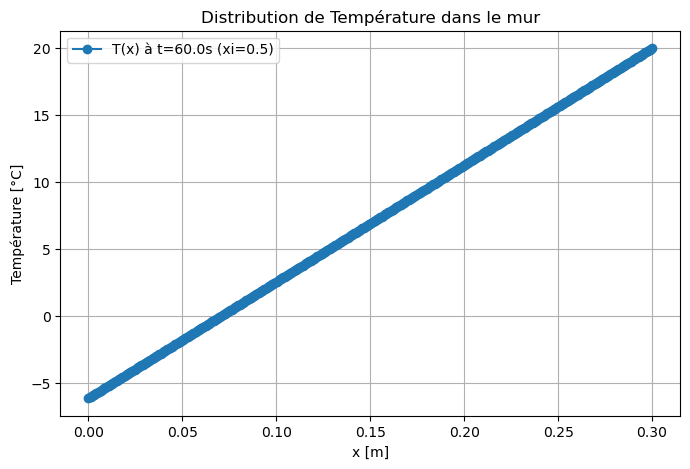

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Paramètres du problème
# =============================================================================
L     = 0.30         # Épaisseur du mur [m]
Nx    = 500           # Nombre d'intervalles spatiaux => Nx+1 nœuds
dx    = L / Nx       # Pas d'espace
x     = np.linspace(0, L, Nx+1)

k     = 0.85         # Conductivité thermique [W/(m*K)]
h     = 20.0         # Coefficient de convection [W/(m^2*K)]
rho   = 2000.0       # Masse volumique [kg/m^3]
C_v   = 1000.0       # Capacité thermique massique [J/(kg*K)]
q     = 2000.0       # Taux volumique d’émission de chaleur [W/m^3]
dL    = 0.05         # Longueur caractéristique pour moduler la source
T_a   = -10.0        # Température ambiante extérieure [°C]
T_i   = 20.0         # Température imposée à x=L [°C]

dt     = 0.05        # Pas de temps [s]
t_final= 60.0        # Durée totale de simulation [s]
nSteps = int(t_final/dt)

xi     = 0.5         # xi=0.5 => Crank–Nicolson ; xi=1 => implicite total.

# =============================================================================
# Condition initiale
# =============================================================================
T_w = ( (k/L)*T_i + h*T_a ) / ( (k/L) + h )
T   = T_w + (T_i - T_w)*(x/L)

# =============================================================================
# Construction du Laplacien "classique" 1D
# =============================================================================
Lap = np.zeros((Nx+1, Nx+1))
for i in range(1, Nx):
    Lap[i, i-1] =  1.0
    Lap[i, i]   = -2.0
    Lap[i, i+1] =  1.0
# Les conditions aux limites seront ajustées dans la boucle en temps.

# =============================================================================
# Boucle en temps
# =============================================================================
for n in range(nSteps):
    # Coeffs utiles
    coeffM  = (C_v * rho) / dt
    coeffCN = (k / (dx*dx)) * dt
    
    # A_prime = M - xi*dt*k*Lap / dx^2
    A_prime = coeffM * np.eye(Nx+1) - ( xi * coeffCN ) * Lap
    
    # b_vec = M*T^n + (1-xi)*dt*k*Lap/dx^2 * T^n  +  S(x)*dt
    b_vec   = coeffM * T
    b_vec  += ( (1.0 - xi)* coeffCN ) * (Lap @ T)
    
    # Terme source
    Sx = q * (1 + ((x - L)/dL)**2)
    b_vec += Sx * dt
    
    # Condition de convection (Robin) à x=0
    A_prime[0, :] = 0.0
    A_prime[0, 0] = coeffM + xi * coeffCN * (k/dx + h) / k
    A_prime[0, 1] = - xi * coeffCN * (k/dx) / k
    b_vec[0]      = ( coeffM*T[0]
                      + (1.0 - xi)* coeffCN*(Lap[0,:] @ T)
                      + (Sx[0]*dt)
                      + xi * coeffCN * (h*T_a)/k )
    
    # Condition de Dirichlet T(L) = T_i
    A_prime[Nx, :]  = 0.0
    A_prime[Nx, Nx] = 1.0
    b_vec[Nx]       = T_i
    
    # Résolution
    T_new = np.linalg.solve(A_prime, b_vec)
    
    # Mise à jour
    T = T_new

# =============================================================================
# Affichage
# =============================================================================
plt.figure(figsize=(8,5))
plt.plot(x, T, 'o-', label=f'T(x) à t={t_final:.1f}s (xi={xi})')
plt.xlabel('x [m]')
plt.ylabel('Température [°C]')
plt.title('Distribution de Température dans le mur')
plt.legend()
plt.grid(True)
plt.show()